# Microgrid with PV, battery and a dispatchable generator

Demo of main data structures and functions of [Microgrids.jl](https://github.com/Microgrids-X/Microgrids.jl).
Main steps are:

1. Describe the Microgrid project and components
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

In [4]:
]status

Project Microgrids v1.0.0-dev
Status `~/Travail/31 Programmes divers/10 MicroGrid/Microgrids.jl/Project.toml` (empty project)


In [1]:
using Microgrids
using CSV, DataFrames, Statistics

In [12]:
using PyPlot # For plotting only. Can be skipped or commented out

In [13]:
with_plots = isdefined(Main, :PyPlot)

true

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar and wind data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

In [14]:
data = DataFrame(CSV.File("$(@__DIR__)/data/Ouessant_data_2016.csv"))

# Simulation steps
nsteps = length(data.Load)
@assert(nsteps == 8760) # 1 year at an hourly timestep

# Split load and solar data:
Pload = data.Load # kW
Ppv1k =  data.Ppv1k ./ 1000; # convert to kW/kWp
mean(Ppv1k) # yearly capacity factor of 12% (quite low in 2016 in Ouessant)

0.1182560696347032

Display load time series

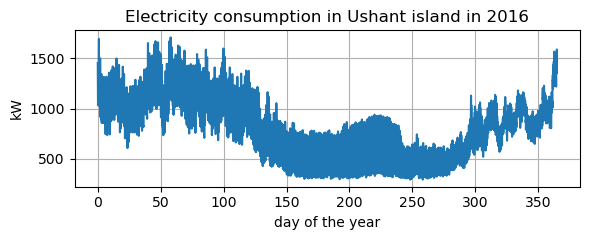

In [15]:
td = collect((0:nsteps-1)/24) # time in days

if with_plots
    fig, ax = plt.subplots(1,1, figsize=(6,2.5))
    ax.plot(td, Pload, label="load")
    
    ax.grid(true)
    ax.set(
        title="Electricity consumption in Ushant island in 2016",
        ylabel="kW",
        xlabel="day of the year"
    )
    fig.tight_layout()
end

## Microgrid description

Describe the Microgrid project and its components using dedicated data structures

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [16]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1. # h

project = Project(lifetime, discount_rate, timestep, "€")

Project(25, 0.05, 1.0, "€")

Parameters common to all Components (but they could differ)

- replacement price relative to initial investment price
- salvage price relative to initial investment price

In [17]:
replacement_price_ratio = 1.0
salvage_price_ratio = 1.0

1.0

### Dispatchable generator (Diesel)

Used as last recourse when there is not enough solar production and the battery is empty

In [18]:
power_rated_gen = 1800.  # rated power (kW) → /2 to see some load shedding
fuel_intercept = 0.0 # fuel curve intercept (L/h/kW_max)
fuel_slope = 0.240 # fuel curve slope (L/h/kW)
fuel_price = 1. # fuel price ($/L)
investment_price_gen = 400. # initial investiment price ($/kW)
om_price_gen = 0.02 # operation & maintenance price ($/kW/h of operation)
lifetime_gen = 15000. # generator lifetime (h)
load_ratio_min = 0.0 # minimum load ratio ∈ [0,1]
fuel_unit = "L" # fuel quantity unit (used in fuel price and consumption curve parameters)

generator = DispatchableGenerator(power_rated_gen,
    fuel_intercept, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen, lifetime_gen,
    load_ratio_min,
    replacement_price_ratio, salvage_price_ratio, fuel_unit)

DispatchableGenerator{Float64}(1800.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L")

### Battery energy storage

Used as a buffer between the solar production and the consumption

In [21]:
energy_rated_sto = 9000. # rated energy capacity (kWh)
investment_price_sto = 350. # initial investiment price ($/kWh)
om_price_sto = 10. # operation and maintenance price ($/kWh/y)
lifetime_sto = 15. # calendar lifetime (y)
lifetime_cycles = 3000. # maximum number of cycles over life (1)
charge_rate = 1.0 # max charge power for 1 kWh (kW/kWh = h^-1)
discharge_rate = 1.0 # max discharge power for 1 kWh (kW/kWh = h^-1)
loss_factor_sto = 0.05 # linear loss factor α (round-trip efficiency is about 1 − 2α) ∈ [0,1]
SoC_min = 0. # minimum State of Charge ∈ [0,1]
SoC_ini = 0. # initial State of Charge ∈ [0,1]

battery = Battery(energy_rated_sto,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
    replacement_price_ratio, salvage_price_ratio)

Battery{Float64}(9000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0)

### Photovoltaic generation

Used in priority to feed the load. PV is proportional to the irradiance data the previous section

In [23]:
power_rated_pv = 6000. # rated power (kW)
irradiance = Ppv1k # global solar irradiance incident on the PV array (kW/m²)
investment_price_pv = 1200. # initial investiment price ($/kW)
om_price_pv = 20.# operation and maintenance price ($/kW)
lifetime_pv = 25. # lifetime (y)
derating_factor_pv = 1.0 # derating factor (or performance ratio) ∈ [0,1]"

photovoltaic = Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)

Photovoltaic{Float64}(6000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)
- PV production is computed by calling the `production` method on the `Photovoltaic` instance

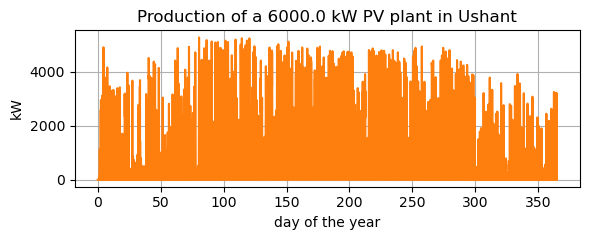

In [26]:
if with_plots
    fig, ax = plt.subplots(1,1, figsize=(6,2.5))

    ax.plot(td, production(photovoltaic), "C1")

    ax.grid(true)
    ax.set(
        title="Production of a $power_rated_pv kW PV plant in Ushant",
        ylabel="kW",
        xlabel="day of the year"
    );
    fig.tight_layout()
end

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components: generator, battery, renewable power generators

In [27]:
microgrid = Microgrid(project, Pload, generator, battery, [photovoltaic]);

## Simulate the microgrid

In [29]:
oper_traj, oper_stats, mg_costs = simulate(microgrid);

#### Costs

`costs` output is of type `MicrogridCosts`, with fields such as `lcoe` and a detailed cost break down

In [30]:
mg_costs.npc/1e6 # M$

26.25501314274826

In [31]:
mg_costs.lcoe # $/kWh

0.26186799832590724

Was (before July 2023 refactor):
- NPC: 28.353 M$

- LCOE: 0.28279 $/kWh

--- 
*TO BE CONTINUED...*

#### Operational statistics

`oper_stats` is of type `OperVarsAgg` with fields such as `renewables_rate`, `shedding_rate`...

In [14]:
oper_stats.renewables_rate # %

58.74028997693115

In [15]:
oper_stats.fuel_consumption # liters

670880.8054857135

served energy (per year), versus desired load:

In [16]:
oper_stats.energy_served/1e6, sum(Pload)*timestep/1e6 # GWh

(6.774979, 6.774979)

In [17]:
oper_stats.energy_shedding_total/1e6 # GWh

0.0

In [18]:
oper_stats.shedding_rate # %?

0.0

In [19]:
oper_stats

OperVarsAggr(6.774979e6, 0, 0, 0, 0.0, 3327, 670880.8054857135, 1.881753568922309e6, 4569.3, 58.74028997693115)

#### Operational trajectories

`oper_traj` is of type `oper_traj` with fields such as `Pgen` (generator power), `Pbatt` (battery power)...

### Display operation trajectories

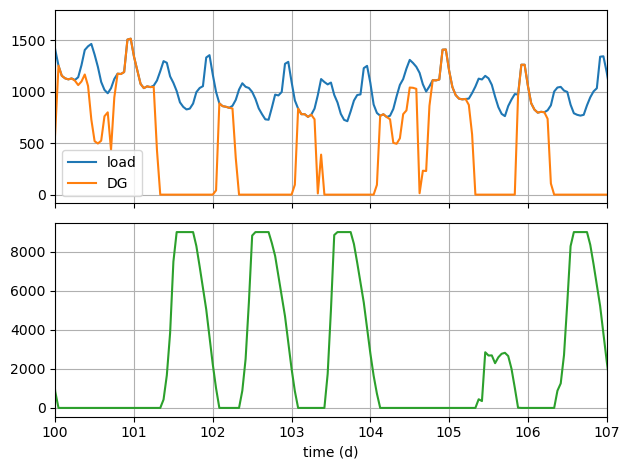

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=true)
ax1.plot(t, Pload, label="load")
ax1.plot(t, oper_traj.Pgen, label="DG")
#ax1.plot(t, oper_traj.Pbatt)
ax2.plot(t, oper_traj.Ebatt[1:end-1], "C2")

ax1.legend()
ax1.grid(true)
ax2.grid(true)
ax2.set(
    xlabel="time (d)"
)

d0 = 100
plt.xlim(d0,d0+7)
fig.tight_layout()

## Microgrid sizing optimization

DRAFT

In [65]:
using NLopt

### How it is done now 

Manually recreate components by mixing input components and input x

In [142]:
function obj_multi(x)
    # split and 
    power_rated_DG = x[1]*1000
    bat_Erated = x[2]*1000
    power_rated_PV = x[3]*1000
    pv = Photovoltaic(power_rated_PV, fPV, IT, IS, investiment_cost_PV, om_cost_PV, replacement_cost_PV, salvage_cost_PV, lifetime_PV)
    batt = Battery(energy_initial, bat_Erated, energy_min, power_min, power_max, loss, investiment_cost_BT, om_cost_BT, replacement_cost_BT, salvage_cost_BT, lifetime_BT, lifetime_thrpt)
    gen = DieselGenerator(power_rated_DG, min_load_ratio, F0, F1, fuel_cost, investiment_cost_DG, om_cost_DG, replacement_cost_DG, salvage_cost_DG, lifetime_DG)
    mg = Microgrid(project, Pload, gen, batt, [pv])
    
    traj, aggr, costs = simulate(mg)
    
    # Extract KPIs of interest
    npc = costs.npc # $
    Eshed = aggr.energy_shedding_total; # kWh/yr
    return npc, Eshed
end

# Logging of objective function calls
#x_hist = Vector{Float64}()
#J_hist = Vector{Float64}()
#nobj = 0

function obj(x, grad)
    global x_hist, J_hist, nobj 
    npc, Eshed = obj_multi(x)
    # TODO: replace project lifetime by sum discount factors = 1/CRF
    pshed = 3. # $/kWh shedding price
    J = (npc + pshed*Eshed*project.lifetime)/1e6
    #println("x=",x,", npc=",npc/1e6, "M\$, Eshed=", Eshed/1e6, "GWh, J=",J)
    #append!(x_hist, x)
    #append!(J_hist, J)
    #nobj += 1
    J
end

obj (generic function with 2 methods)

test the objective function

In [110]:
obj_multi([1e-3 0. 0.]), obj_multi([power_rated_DG energy_max power_rated_PV]/1000)

((35618.441965931306, 6.766219e6), (2.8353000758421674e7, 0))

In [111]:
obj([1e-3 0. 0.]), obj([power_rated_DG energy_max power_rated_PV]/1000)

(507.50204344196595, 28.353000758421675)

In [196]:
Pload_max = maximum(Pload)
x0 = [Pload_max, 5*Pload_max, 3*Pload_max]/1000
xmax = [1.1*Pload_max, Pload_max*10, Pload_max*10]/1000
obj(x0)

27.620445714437132

In [197]:
obj(xmax)

41.526456095420734

In [198]:
[xmin x0 xmax]

3×3 Matrix{Float64}:
 1.0e-6  1.707   1.8777
 1.0e-6  8.535  17.07
 1.0e-6  5.121  17.07

In [208]:
nx = 3 # number of optim variables
opt = Opt(:LN_NELDERMEAD, nx)
opt = Opt(:LN_SBPLX, nx)
#opt = Opt(:GN_DIRECT, nx)
opt = Opt(:GN_ESCH, nx)
NLopt.srand(1) # for repetability of random algos

xmin = [1e-6, 1e-6, 1e-6]
opt.lower_bounds = xmin
opt.upper_bounds = xmax
opt.min_objective = obj
opt.xtol_rel = 1e-4
opt.maxeval = 1000 # ~ 15s d'optim

(minf,minx,ret) = optimize(opt, x0)

(27.244080174285777, [1.574230105557986, 7.599278040207289, 5.121], :MAXEVAL_REACHED)

In [185]:
obj_multi(minx)

(2.6750432808214374e7, 3324.020872331298)

In [201]:
opt.numevals

1000

SUBPLX with x0 as starting point: (OUDATED: x0 was changed)

26.941898251964574, [1.4991124869446102, 7.150779568969208, 4.245762916502811]

SUBPLX with x0*0.3 as starting point: (OUDATED: x0 was changed)

26.99973437363922, [1.4929778071232327, 6.430732540624913, 3.89298559515736]

#### Performance of the optimization

simulator takes ~12 ms. That's the main cause of the optimization length

In [133]:
@time oper_traj, oper_stats, costs = simulate(microgrid);

  0.011756 seconds (407.56 k allocations: 7.628 MiB)


Check: Toptim ~ Tsim × neval

In [211]:
0.012*269 # s

3.228

In [135]:
@time (minf,minx,ret) = optimize(opt, x0)

  3.653020 seconds (115.92 M allocations: 2.098 GiB, 7.73% gc time)


(26.941898251964574, [1.4991124869446102, 7.150779568969208, 4.245762916502811], :XTOL_REACHED)

Number of "equivalent time series" being allocated: too large!

In [210]:
7.6e6/8/8760

108.44748858447488

Looking at types: the simulator output are not well typed, but the problem is probably deeper inside Microgrids.jl

In [144]:
@code_warntype obj_multi(x0);

MethodInstance for obj_multi(::Vector{Float64})
  from obj_multi(x) in Main at In[142]:1
Arguments
  #self#::Core.Const(obj_multi)
  x::Vector{Float64}
Locals
  @_3::Int64
  @_4::Int64
  Eshed::Any
  npc::Any
  costs::MicrogridCosts
  aggr::OperVarsAggr
  traj::OperVarsTraj
  mg::Microgrid
  gen::DieselGenerator
  batt::Battery
  pv::Photovoltaic
  power_rated_PV::Float64
  bat_Erated::Float64
  power_rated_DG::Float64
Body::Tuple{Any, Any}
1 ─ %1  = (x * 1000)::Vector{Float64}
│   %2  = Base.indexed_iterate(%1, 1)::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(2)])
│         (power_rated_DG = Core.getfield(%2, 1))
│         (@_4 = Core.getfield(%2, 2))
│   %5  = Base.indexed_iterate(%1, 2, @_4::Core.Const(2))::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(3)])
│         (bat_Erated = Core.getfield(%5, 1))
│         (@_4 = Core.getfield(%5, 2))
│   %8  = Base.indexed_iterate(%1, 3, @_4::Core.Const(3))::Core.PartialStruct(Tuple{Float64, Int64}, An

### How we would like it to be

dynamically select which variables are optimized

In [ ]:
opti_params = [
    ([:dieselgenator,:power_rated], 1800.0),
    ([:battery,:energy_max], 1800.0)
]
optimize(mg0, opti_params)

In [ ]:
function set_field(component, name, value)
    "something like component.$name = value, but for immutable Type"

In [41]:
name = :power_rated
getproperty(dieselgenerator, name)

1800.0

In [71]:
getproperty(getproperty(microgrid, :dieselgenerator), name)

1800.0